Step 1: Imports

In [ ]:
! git clone https://github.com/niharikavadapalli/ERA-V1.git

Cloning into 'ERA-V1'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 275 (delta 25), reused 35 (delta 12), pack-reused 220
Receiving objects: 100% (275/275), 1.86 MiB | 9.67 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
%cd "/content/ERA-V1/ERA-V1-Session-10"
!pwd

/content/ERA-V1/ERA-V1-Session-10
/content/ERA-V1/ERA-V1-Session-10


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

from cifar10.custom_resnet_model import Net
from cifar10.backpropogation import test, train
from cifar10.visualize import plot_misclassified_images, plot_network_performance, print_samples, print_data_stats, print_train_log
from cifar10.backpropogation import train_losses, train_acc, test_losses, test_acc, incorrect_examples, incorrect_pred, incorrect_labels
from cifar10.dataset import MyDataset
from cifar10.transform import get_loaders

!pip install torchsummary
!pip install torch-lr-finder
from torchsummary import summary

Step 2: Visualize and Prepare Data Transforms

100%|██████████| 170498071/170498071 [00:05<00:00, 28619604.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


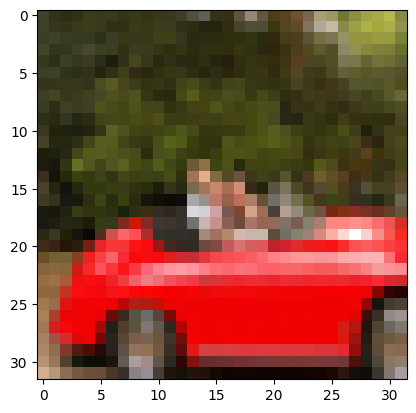

In [ ]:
cifar10 =  datasets.CIFAR10('./data', train=True, download=True)
cifar10_val = datasets.CIFAR10('./data', train=False, download=True)
img, label = cifar10[99]
plt.imshow(img)
plt.show()

Step 4: Creating data loaders

In [ ]:
SEED = 1

cuda = torch.cuda.is_available()
print("Is cuda available? ", cuda)

#set the seed of the random number generator to a fixed value
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

train_loader, test_loader = get_loaders(batch_size=512, use_cuda=cuda)


Is cuda available?  True


100%|██████████| 170498071/170498071 [00:05<00:00, 28975257.45it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


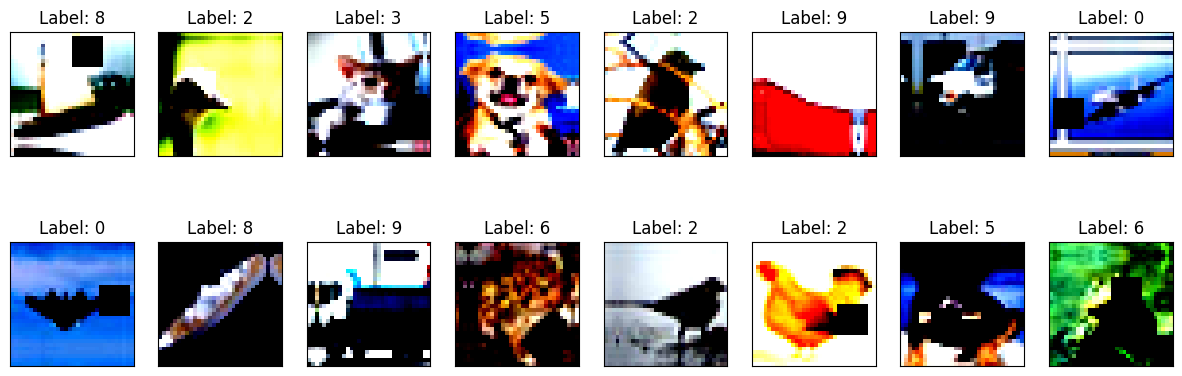

In [ ]:
print_samples(train_loader)

Step 5: Data Stats

In [ ]:
print_data_stats(train_loader)

{'horse': 5000, 'automobile': 5000, 'deer': 5000, 'ship': 5000, 'airplane': 5000, 'bird': 5000, 'dog': 5000, 'frog': 5000, 'cat': 5000, 'truck': 5000}


Step 6: Model Creation and Display Parameters

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.80E-02


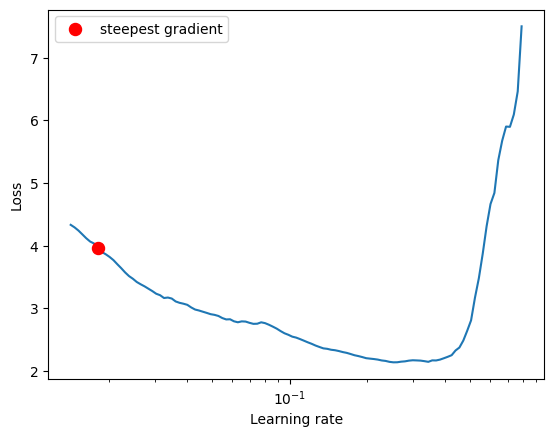

In [ ]:
from torch_lr_finder import LRFinder

#model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Step 7: Training the model

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

FOUND_LR = 1.80E-02

EPOCHS = 24
train_acc.clear()
test_acc.clear()
train_losses.clear()
test_losses.clear()
incorrect_examples.clear()
incorrect_labels.clear()
incorrect_pred.clear()
learning_rates = []

scheduler = OneCycleLR(
        optimizer,
        max_lr=FOUND_LR,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    print(f"\n current learing rate is {optimizer.param_groups[0]['lr']}")
    print(f"\n last test loss is {test_losses[-1]}")


EPOCH: 0


Loss=1.1126806735992432 Batch_id=97 Accuracy=46.6280: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0022, Accuracy: 6136/10000 (61.3600%)


 current learing rate is 0.003751288343558282

 last test loss is 0.002151478523015976
EPOCH: 1


Loss=0.7540268898010254 Batch_id=97 Accuracy=65.6620: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0018, Accuracy: 6881/10000 (68.8100%)


 current learing rate is 0.007322576687116563

 last test loss is 0.0018322319447994233
EPOCH: 2


Loss=0.7194770574569702 Batch_id=97 Accuracy=72.9160: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]



Test set: Average loss: 0.0023, Accuracy: 6532/10000 (65.3200%)


 current learing rate is 0.010893865030674845

 last test loss is 0.0023119002878665925
EPOCH: 3


Loss=0.6763842701911926 Batch_id=97 Accuracy=75.5340: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]



Test set: Average loss: 0.0022, Accuracy: 6921/10000 (69.2100%)


 current learing rate is 0.014465153374233127

 last test loss is 0.0021629488348960876
EPOCH: 4


Loss=0.5697674751281738 Batch_id=97 Accuracy=78.0140: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]



Test set: Average loss: 0.0016, Accuracy: 7386/10000 (73.8600%)


 current learing rate is 0.017990333941997852

 last test loss is 0.0016376431941986084
EPOCH: 5


Loss=0.6422145366668701 Batch_id=97 Accuracy=79.7240: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]



Test set: Average loss: 0.0012, Accuracy: 8027/10000 (80.2700%)


 current learing rate is 0.017043060257787325

 last test loss is 0.00120357469022274
EPOCH: 6


Loss=0.5700736045837402 Batch_id=97 Accuracy=82.4820: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]



Test set: Average loss: 0.0014, Accuracy: 7728/10000 (77.2800%)


 current learing rate is 0.016095786573576798

 last test loss is 0.0014344024181365967
EPOCH: 7


Loss=0.4959784150123596 Batch_id=97 Accuracy=82.9980: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]



Test set: Average loss: 0.0012, Accuracy: 8023/10000 (80.2300%)


 current learing rate is 0.015148512889366271

 last test loss is 0.0011953683018684387
EPOCH: 8


Loss=0.39000651240348816 Batch_id=97 Accuracy=84.1000: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 0.0009, Accuracy: 8457/10000 (84.5700%)


 current learing rate is 0.014201239205155746

 last test loss is 0.0009213203549385071
EPOCH: 9


Loss=0.5741432309150696 Batch_id=97 Accuracy=84.6860: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 0.0010, Accuracy: 8368/10000 (83.6800%)


 current learing rate is 0.013253965520945219

 last test loss is 0.0009503664314746856
EPOCH: 10


Loss=0.3929426670074463 Batch_id=97 Accuracy=85.6580: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 0.0009, Accuracy: 8476/10000 (84.7600%)


 current learing rate is 0.012306691836734693

 last test loss is 0.0008806093364953994
EPOCH: 11


Loss=0.4623506963253021 Batch_id=97 Accuracy=85.9680: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 0.0009, Accuracy: 8550/10000 (85.5000%)


 current learing rate is 0.011359418152524167

 last test loss is 0.0008719986468553544
EPOCH: 12


Loss=0.4247877895832062 Batch_id=97 Accuracy=86.7160: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 0.0008, Accuracy: 8559/10000 (85.5900%)


 current learing rate is 0.01041214446831364

 last test loss is 0.0008390484422445297
EPOCH: 13


Loss=0.4036705791950226 Batch_id=97 Accuracy=86.8760: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]



Test set: Average loss: 0.0008, Accuracy: 8658/10000 (86.5800%)


 current learing rate is 0.009464870784103114

 last test loss is 0.0008070945978164673
EPOCH: 14


Loss=0.3906337320804596 Batch_id=97 Accuracy=87.6380: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]



Test set: Average loss: 0.0008, Accuracy: 8556/10000 (85.5600%)


 current learing rate is 0.008517597099892587

 last test loss is 0.0008368862599134445
EPOCH: 15


Loss=0.4369288980960846 Batch_id=97 Accuracy=88.2480: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]



Test set: Average loss: 0.0009, Accuracy: 8636/10000 (86.3600%)


 current learing rate is 0.007570323415682062

 last test loss is 0.0008613121122121811
EPOCH: 16


Loss=0.3974685072898865 Batch_id=97 Accuracy=89.0940: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]



Test set: Average loss: 0.0007, Accuracy: 8822/10000 (88.2200%)


 current learing rate is 0.006623049731471535

 last test loss is 0.0007020660907030105
EPOCH: 17


Loss=0.30151572823524475 Batch_id=97 Accuracy=89.8640: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 0.0009, Accuracy: 8591/10000 (85.9100%)


 current learing rate is 0.005675776047261008

 last test loss is 0.0008865614026784896
EPOCH: 18


Loss=0.27762287855148315 Batch_id=97 Accuracy=90.4520: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 0.0006, Accuracy: 8947/10000 (89.4700%)


 current learing rate is 0.004728502363050483

 last test loss is 0.0006430753856897354
EPOCH: 19


Loss=0.23159925639629364 Batch_id=97 Accuracy=91.4860: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.1000%)


 current learing rate is 0.003781228678839956

 last test loss is 0.0005766943171620369
EPOCH: 20


Loss=0.23283442854881287 Batch_id=97 Accuracy=92.6800: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 0.0006, Accuracy: 9058/10000 (90.5800%)


 current learing rate is 0.0028339549946294305

 last test loss is 0.0005512599900364876
EPOCH: 21


Loss=0.16759012639522552 Batch_id=97 Accuracy=93.7680: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 0.0005, Accuracy: 9170/10000 (91.7000%)


 current learing rate is 0.0018866813104189036

 last test loss is 0.0005126178145408631
EPOCH: 22


Loss=0.1452469527721405 Batch_id=97 Accuracy=95.1360: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 0.0005, Accuracy: 9251/10000 (92.5100%)


 current learing rate is 0.0009394076262083766

 last test loss is 0.00045903352200984954
EPOCH: 23


Loss=0.09569469094276428 Batch_id=97 Accuracy=96.2560: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 0.0004, Accuracy: 9311/10000 (93.1100%)


 current learing rate is -7.866058002146958e-06

 last test loss is 0.0004294259995222092


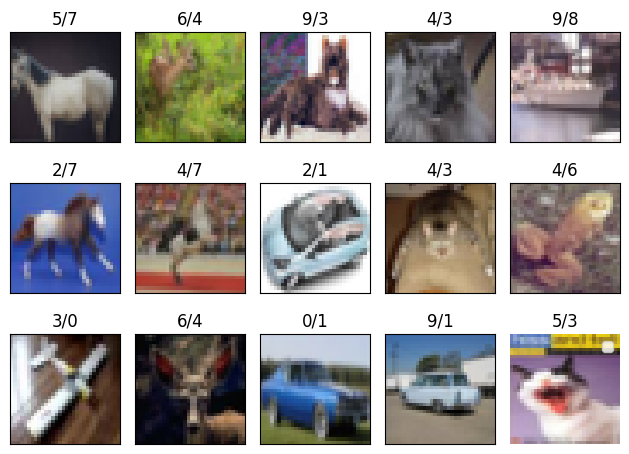

In [ ]:
plot_misclassified_images(incorrect_examples, incorrect_pred, incorrect_labels)


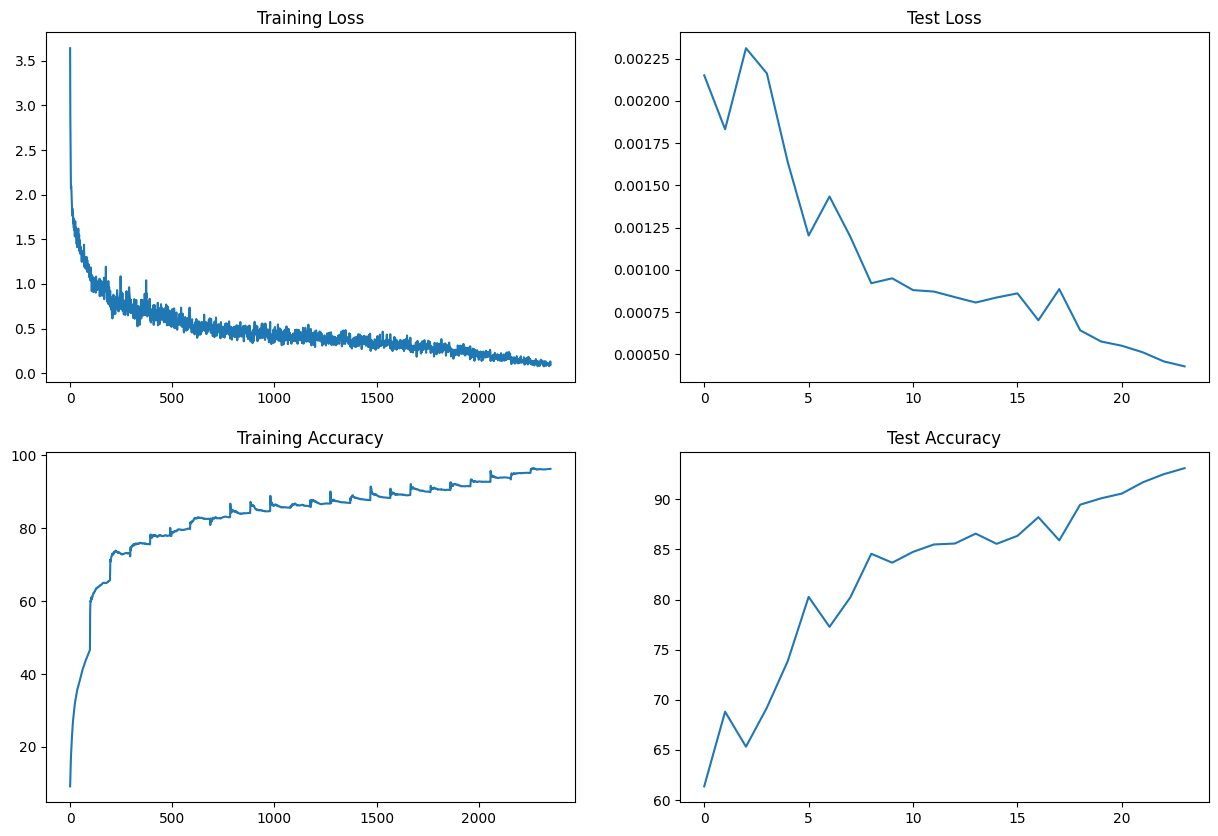

In [ ]:
new_tensor = torch.tensor(train_losses, device = 'cpu')
plot_network_performance(new_tensor, test_losses, train_acc, test_acc)

In [ ]:
print_train_log(EPOCHS, train_acc, test_acc, train_losses, test_losses, learning_rates)


Epoch	     Train Loss	     Test Loss     Train Accuracy    Test Accuracy    Learning Rate
1		3.64		0.00		9.1797		61.3600		0.00375129

2		2.89		0.00		11.3281		68.8100		0.00732258

3		2.60		0.00		13.3464		65.3200		0.01089387

4		2.27		0.00		15.3320		69.2100		0.01446515

5		2.07		0.00		17.1094		73.8600		0.01799033

6		2.10		0.00		18.3268		80.2700		0.01704306

7		2.08		0.00		19.5871		77.2800		0.01609579

8		2.01		0.00		20.8740		80.2300		0.01514851

9		1.95		0.00		21.8099		84.5700		0.01420124

10		1.88		0.00		22.7734		83.6800		0.01325397

11		1.79		0.00		23.5440		84.7600		0.01230669

12		1.84		0.00		24.4466		85.5000		0.01135942

13		1.76		0.00		25.5108		85.5900		0.01041214

14		1.79		0.00		26.2835		86.5800		0.00946487

15		1.78		0.00		26.9922		85.5600		0.00851760

16		1.72		0.00		27.7100		86.3600		0.00757032

17		1.67		0.00		28.1710		88.2200		0.00662305

18		1.72		0.00		28.5916		85.9100		0.00567578

19		1.63		0.00		29.2558		89.4700		0.00472850

20		1.73		0.00		29.7266		90.1000		0.00378123


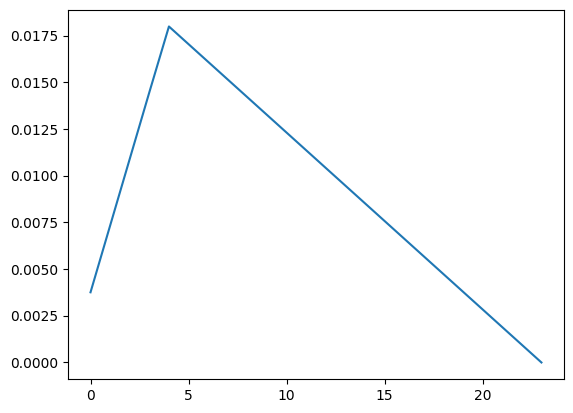

In [ ]:
plt.plot(learning_rates)